In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import seaborn as sns
%matplotlib inline

In [2]:
mu_ = 100 #mean
sigma_ = 10 #standard deviation

population = np.round(np.random.normal(mu_, sigma_, 10000), 2)

In [3]:
mu = population.mean()

In [4]:
sigma = population.std()

In [5]:
sample_size = 5

In [6]:
se = sigma / sample_size ** 0.5
se

4.512127820712507

In [7]:
sample = np.random.choice(population, sample_size, False)

In [8]:
z_scores = []

In [9]:
n = 10000
for i in range(n):
    sample = np.random.choice(population, sample_size, False)
    sample_mean = sample.mean()
    
    z_score = (sample_mean - mu) / se
    z_scores.append(z_score)

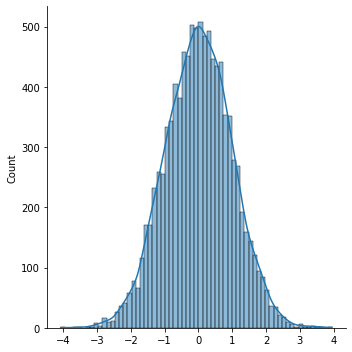

In [10]:
sns.displot(z_scores, kde=True)

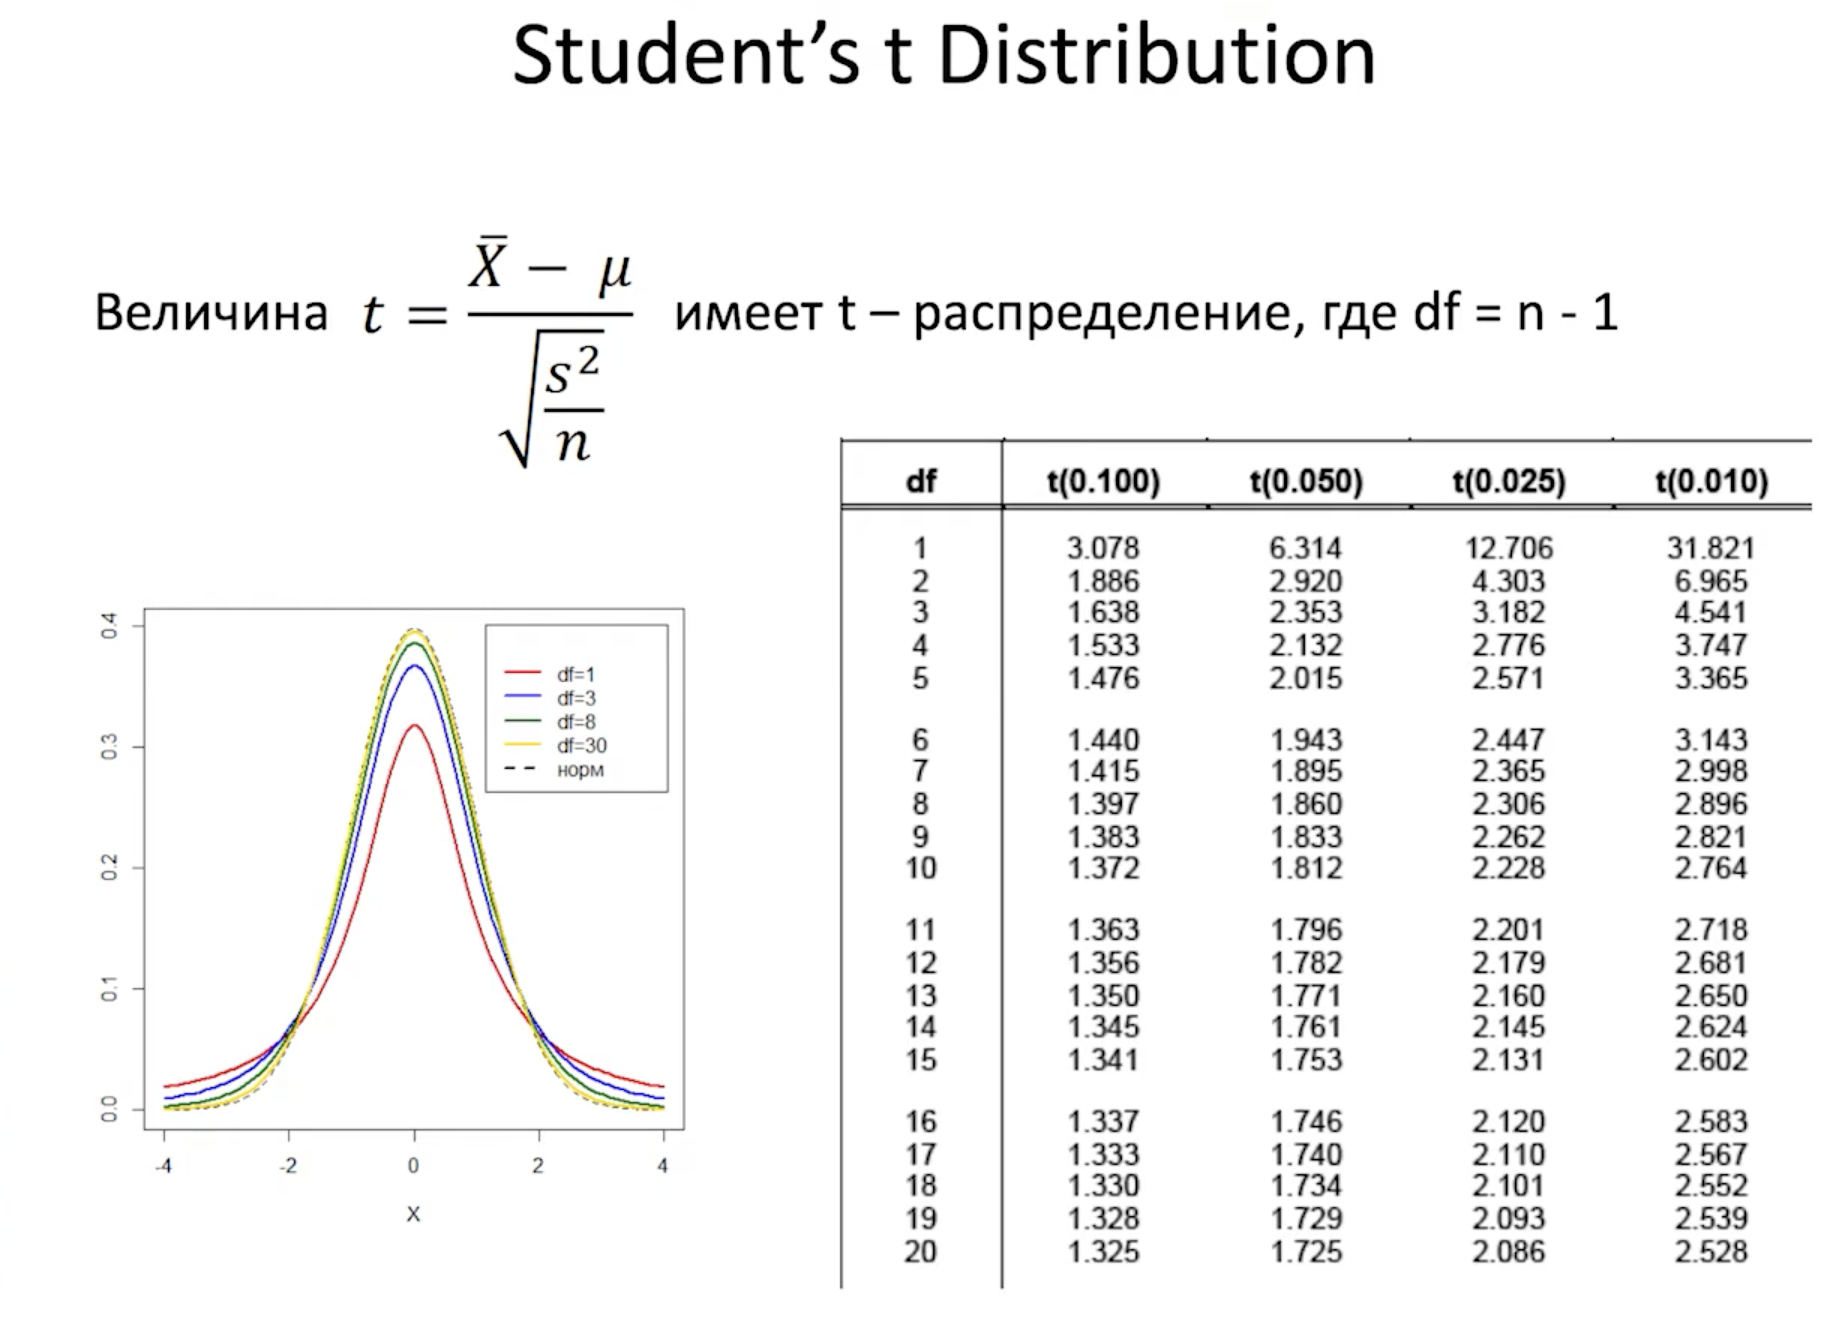

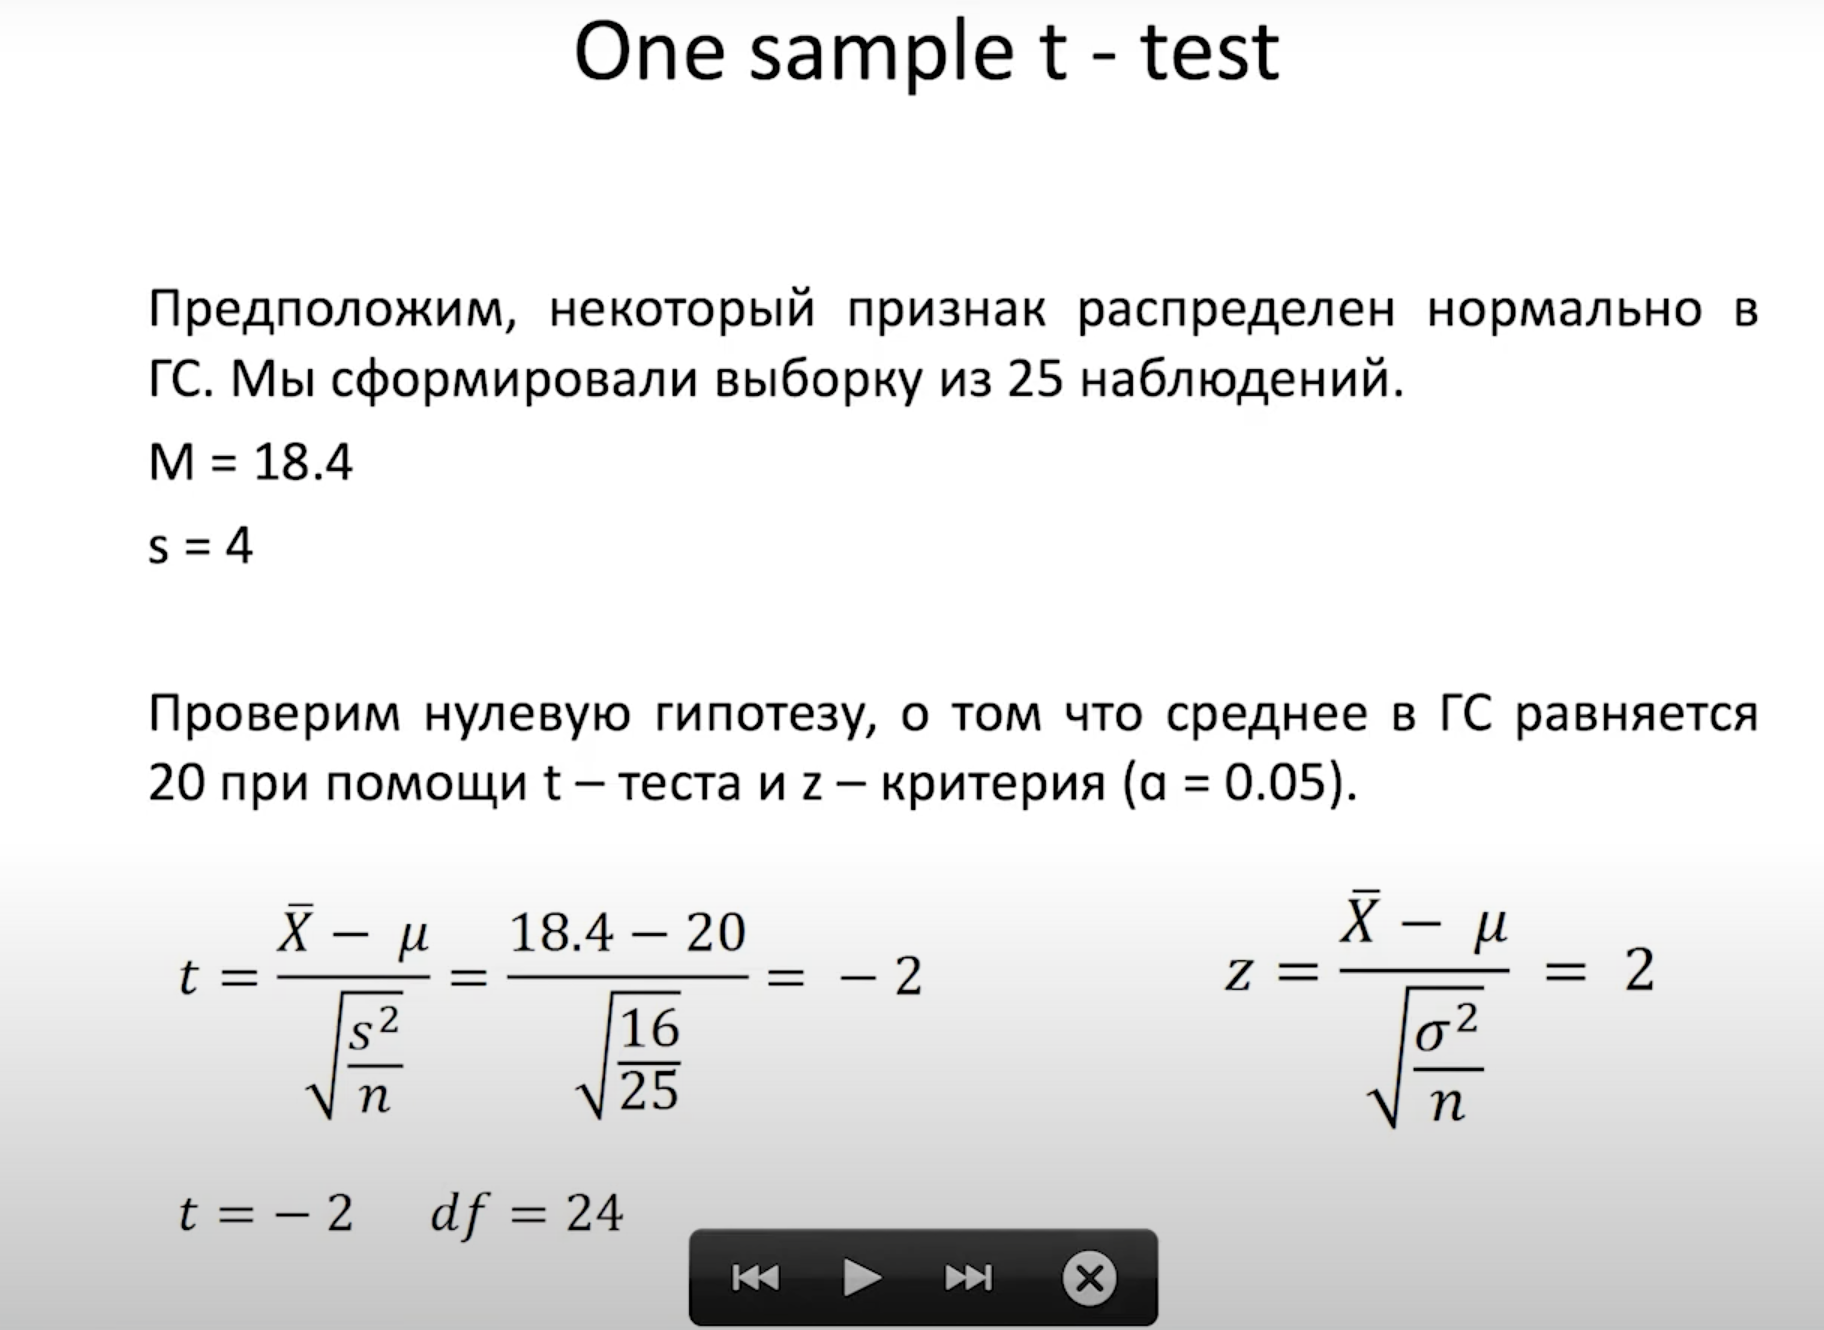

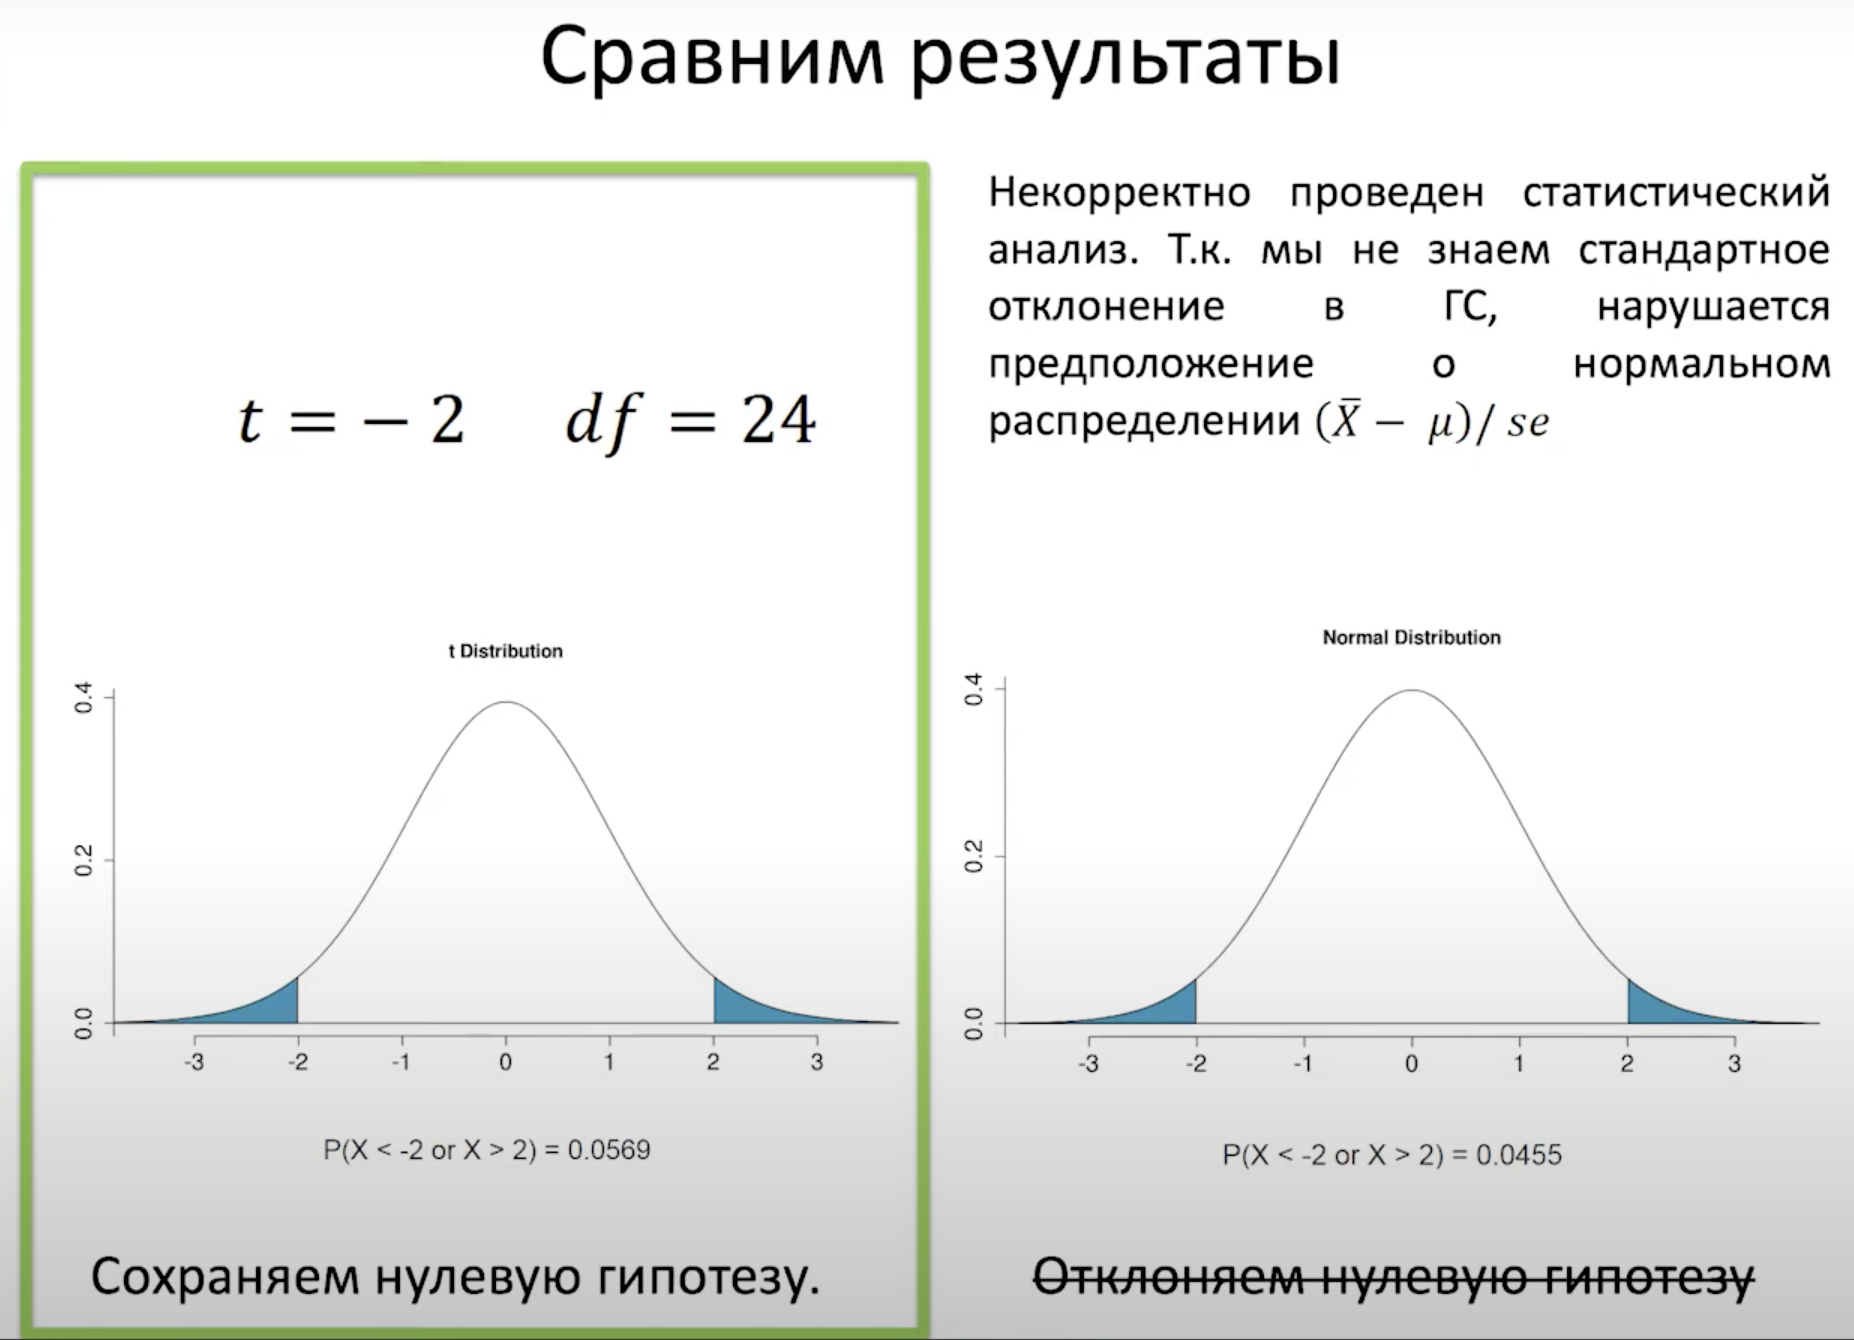

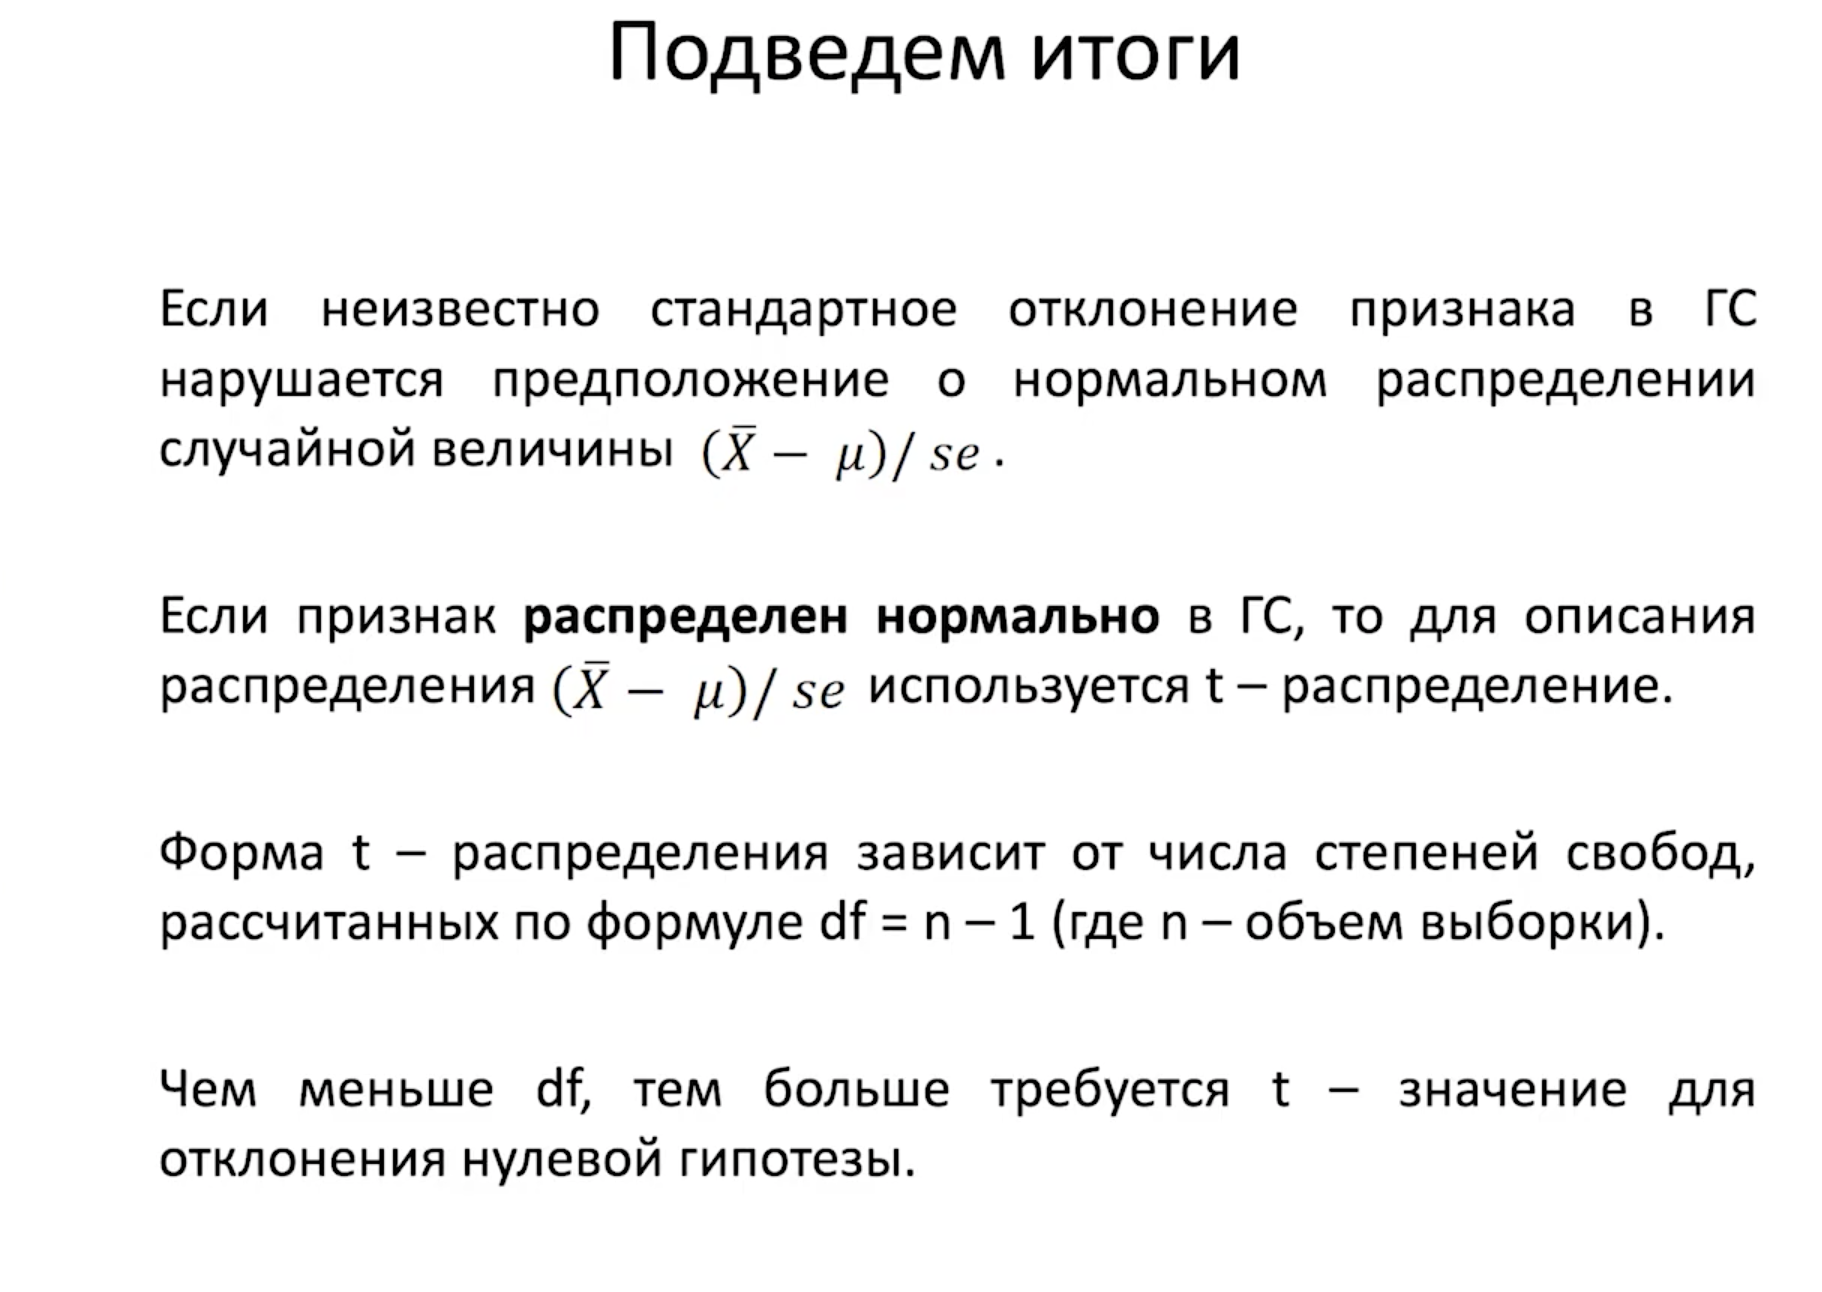

In [11]:
# все то же самое, только вместо сигмы берем стандартное отклонение выборки
# так как в реальности мы никогда не знаем сигму
# чем меньше выборка, тем больше больше будет диапазон значений, больше 30 - уже ок, можно использовать нормальное распределение

In [12]:
# степени свободы это размер выборки - 1
degrees_of_freedom = sample_size - 1
degrees_of_freedom

4

In [13]:
t_scores = []

In [14]:
n = 10000
for i in range(n):
    sample = np.random.choice(population, sample_size, False)
    sample_mean = sample.mean()
    sample_std = sample.std()
    
    se_ = sample_std / sample_size ** 0.5
    
    t_score = (sample_mean - mu) / se_
    t_scores.append(t_score)

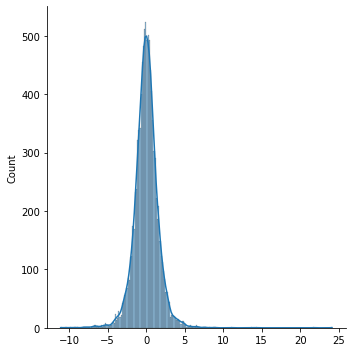

In [15]:
sns.displot(t_scores, kde=True)

In [16]:
ads_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-alibekov/shared/ads_data.csv.zip')

In [17]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [18]:
df = ads_data.groupby(['ad_id', 'ad_cost_type', 'platform', 'event'], as_index=False).agg({'user_id':'count'})

In [19]:
df.head()

,ad_id,ad_cost_type,platform,event,user_id
0,3,CPC,android,click,5
1,3,CPC,android,view,244
2,3,CPC,ios,click,3
3,3,CPC,ios,view,147
4,3,CPC,web,click,1


In [20]:
df = df.pivot(index=['ad_id', 'ad_cost_type', 'platform'], columns='event', values='user_id').reset_index()

In [21]:
df.head()

event,ad_id,ad_cost_type,platform,click,view
0,3,CPC,android,5.0,244.0
1,3,CPC,ios,3.0,147.0
2,3,CPC,web,1.0,99.0
3,2132,CPC,android,1.0,55.0
4,2132,CPC,ios,NaN,26.0


In [22]:
platform_df = df.groupby(['ad_id', 'platform'], as_index=False).agg({'click':'sum', 'view':'sum'})

In [23]:
platform_df = platform_df.query('view > 100 & click > 0')

In [24]:
platform_df['ctr'] = platform_df.click / platform_df.view

In [25]:
platform_df['ctr_log'] = np.log(platform_df.ctr)

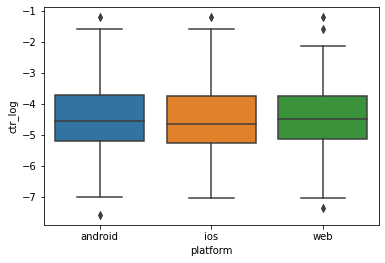

In [26]:
sns.boxplot(data = platform_df, x = 'platform', y = 'ctr_log')

In [27]:
platform_df.groupby('platform').agg({'ctr':'median'})

,ctr
platform,
android,0.010695
ios,0.009554
web,0.011213


In [28]:
ttest_ind(platform_df[platform_df.platform == 'android'].ctr_log, 
          platform_df[platform_df.platform == 'ios'].ctr_log)

Ttest_indResult(statistic=0.37737835082801163, pvalue=0.7060862996066313)

In [29]:
# Среднее в одной группе отличается от других групп / Т-тест для более 2 выборок / ANOVA / 
# Если pvalue < 0.05, то попарно надо было бы сравнить / Этот подход дает понимание имеет ли смысл дальше смотреть

f_oneway(platform_df[platform_df.platform == 'android'].ctr_log, 
          platform_df[platform_df.platform == 'ios'].ctr_log,
          platform_df[platform_df.platform == 'web'].ctr_log)

F_onewayResult(statistic=0.12221144552264535, pvalue=0.884985296331977)

In [30]:
cost_type_df = df.groupby(['ad_id', 'ad_cost_type'], as_index=False).agg({'click':'sum', 'view':'sum'})

In [31]:
cost_type_df.view.median()

478.0

In [32]:
cost_type_df = cost_type_df.query('view > 100 & click > 0')

In [33]:
cost_type_df['ctr'] = cost_type_df.click / cost_type_df.view

In [34]:
cost_type_df

,ad_id,ad_cost_type,click,view,ctr
0,3,CPC,9.0,490.0,0.018367
2,2276,CPC,2.0,1454.0,0.001376
4,2643,CPM,3.0,286.0,0.010490
5,4585,CPC,53.0,476.0,0.111345
6,4877,CPC,5.0,2160.0,0.002315
...,...,...,...,...,...
350,121941,CPM,1.0,640.0,0.001563
351,121943,CPC,15.0,1722.0,0.008711
352,122042,CPM,1.0,155.0,0.006452
353,122063,CPM,1.0,260.0,0.003846


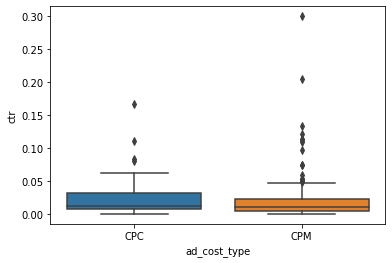

In [35]:
sns.boxplot(data = cost_type_df, x = 'ad_cost_type', y = 'ctr')

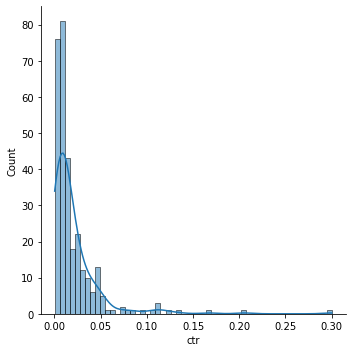

In [36]:
sns.displot(cost_type_df.ctr, kde=True)

In [37]:
cost_type_df.groupby('ad_cost_type').agg({'ctr':'median'})

,ctr
ad_cost_type,
CPC,0.012019
CPM,0.010490


In [38]:
cost_type_df.groupby('ad_cost_type').agg({'ctr':'mean'})

,ctr
ad_cost_type,
CPC,0.024107
CPM,0.019467


In [39]:
x = [10, 15, 20, 200, 4000, 120000000]
np.log(x)

array([ 2.30258509,  2.7080502 ,  2.99573227,  5.29831737,  8.29404964,
       18.6030023 ])

In [40]:
# чтобы не было объявлений с ctr = 0, добавим в начале в условие еще, что click > 0
np.log(0)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


-inf

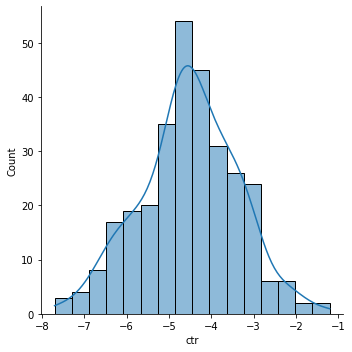

In [41]:
sns.displot(np.log(cost_type_df.ctr), kde=True)

In [42]:
cost_type_df['ctr_log'] = np.log(cost_type_df.ctr)

In [43]:
cost_type_df

,ad_id,ad_cost_type,click,view,ctr,ctr_log
0,3,CPC,9.0,490.0,0.018367,-3.997181
2,2276,CPC,2.0,1454.0,0.001376,-6.588926
4,2643,CPM,3.0,286.0,0.010490,-4.557380
5,4585,CPC,53.0,476.0,0.111345,-2.195126
6,4877,CPC,5.0,2160.0,0.002315,-6.068426
...,...,...,...,...,...,...
350,121941,CPM,1.0,640.0,0.001563,-6.461468
351,121943,CPC,15.0,1722.0,0.008711,-4.743191
352,122042,CPM,1.0,155.0,0.006452,-5.043425
353,122063,CPM,1.0,260.0,0.003846,-5.560682


In [44]:
cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr_log

4     -4.557380
8     -3.751854
9     -4.143135
10    -3.392269
12    -4.727388
         ...   
346   -3.533687
349   -4.424847
350   -6.461468
352   -5.043425
353   -5.560682
Name: ctr_log, Length: 247, dtype: float64

In [45]:
cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr_log

0     -3.997181
2     -6.588926
5     -2.195126
6     -6.068426
7     -3.704823
11    -5.831882
13    -4.018549
14    -4.766438
15    -2.523226
17    -4.884694
19    -6.898715
20    -4.655863
21    -4.139159
25    -3.061386
31    -3.212187
32    -3.459466
34    -3.356746
37    -6.362597
52    -4.897840
54    -4.826712
82    -4.801285
106   -4.525405
117   -5.284218
120   -4.695011
125   -1.787876
151   -4.882802
155   -3.107436
228   -3.791737
245   -4.586242
254   -4.686952
255   -4.881286
256   -3.309630
258   -3.222790
259   -3.530553
266   -5.755215
270   -3.367296
279   -3.672496
284   -2.981276
295   -2.484907
300   -4.337291
301   -4.424847
304   -4.789573
306   -4.382027
321   -3.719651
322   -5.499215
332   -4.465908
333   -3.258097
334   -4.409763
335   -7.006695
336   -4.421247
337   -6.312944
340   -7.013016
348   -2.768245
351   -4.743191
354   -3.688379
Name: ctr_log, dtype: float64

In [46]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr_log, 
          cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr_log)

Ttest_indResult(statistic=-1.1407296867039143, pvalue=0.25489224816951805)

In [47]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr, 
          cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr)

Ttest_indResult(statistic=-1.0366111047153586, pvalue=0.3007519549674309)